https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [1]:
pip install icecream more_itertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# only needed for colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/SYMBA/2022-07-20-RNNAttention')

In [4]:
os.listdir()

['notebooks',
 'README.md',
 'env.yml',
 'dev',
 'source',
 'models',
 '.ipynb_checkpoints']

In [5]:
import sys
import os
from icecream import ic 
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from source.read_amplitudes import read_amplitudes, fix_operator_num_args, get_tree, fix_tree, fix_subscript, fix_subscripts, read_amplitudes_and_squares
  

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras import layers

# Reading in Data

In [7]:
os.listdir()

['notebooks',
 'README.md',
 'env.yml',
 'dev',
 'source',
 'models',
 '.ipynb_checkpoints']

In [8]:
amplitudes_file = "../data.nosync/QED_amplitudes_TreeLevel_UpTo3to3.txt"
sqamplitudes_file = "../data.nosync/QED_sqamplitudes_TreeLevel_UpTo3to3.txt"

In [9]:
X = []
with open(amplitudes_file, 'r') as f:
    for line in f.readlines() :
        line = line.split(";")
        # have to remove new line character for some reason
        line[-1] = line[-1].replace("\n", "")
        # line = tf.strings.join(['[START]', line, '[END]'], separator=' ')
        X.append(['[START]'] + line + ['[END]'])

y = []
with open(sqamplitudes_file, 'r') as f:
    for line in f.readlines() :
        line = line.split(";")
        # have to remove new line character for some reason
        line[-1] = line[-1].replace("\n", "")
        y.append(['[START]'] + line + ['[END]'])

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
X_train[0]

['[START]',
 'Prod',
 '1/162',
 'Prod',
 'i',
 'Prod',
 'Pow',
 'e',
 '4',
 'Prod',
 'Pow',
 'Sum',
 'Pow',
 'm_s',
 '2',
 'Sum',
 's_23',
 'Prod',
 '1/2',
 'reg_prop',
 '-1',
 'Prod',
 'Pow',
 'Sum',
 'Pow',
 'm_s',
 '2',
 'Sum',
 's_12',
 's_13',
 'Prod',
 '-1',
 's_15',
 's_23',
 'Prod',
 '-1',
 's_25',
 'Prod',
 '-1',
 's_35',
 'Prod',
 '1/2',
 'reg_prop',
 '-1',
 'Prod',
 'Pow',
 'Sum',
 's_15',
 'Prod',
 '-1/2',
 'reg_prop',
 '-1',
 'Sum',
 'Prod',
 'p_1',
 'alpha_44',
 'Prod',
 'p_1',
 'alpha_5',
 'Prod',
 'gamma',
 'alpha_44',
 'alpha_33',
 'alpha_13',
 'Prod',
 'gamma',
 'alpha_21',
 'alpha_48',
 'alpha_49',
 'Prod',
 'A^(*)',
 'i_2',
 'alpha_5',
 '(p_5)',
 'Prod',
 'A^(*)',
 'i_3',
 'alpha_21',
 '(p_6)',
 'Prod',
 'd^(*)',
 'i_1',
 'alpha_48',
 '(p_1)_v',
 'Prod',
 'd',
 'i_4',
 'alpha_49',
 '(p_4)_v',
 'Prod',
 's',
 'i_5',
 'alpha_13',
 '(p_2)_u',
 's^(*)',
 'i_0',
 'alpha_33',
 '(p_3)_v',
 'Sum',
 'Prod',
 '1/2',
 'Prod',
 'p_1',
 'alpha_5',
 'Prod',
 'p_2',
 'alpha_6',
 '

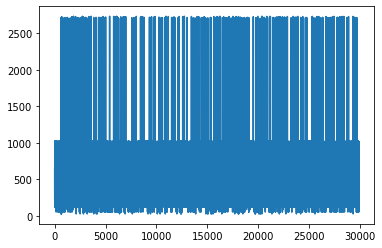

In [13]:
plt.plot([len(x) for x in X_train])

In [87]:
X_train_idx_okay = np.where([len(x) < 250 for x in X_train])[0]
X_test_idx_okay = np.where([len(x) < 250 for x in X_test])[0]
ic(len(X_train_idx_okay));
ic(len(X_test_idx_okay));

ic| len(X_train_idx_okay): 19266
ic| len(X_test_idx_okay): 4854


In [88]:
X_train_short = [X_train[i] for i in X_train_idx_okay]
y_train_short = [y_train[i] for i in X_train_idx_okay]

X_test_short = [X_test[i] for i in X_test_idx_okay]
y_test_short = [y_test[i] for i in X_test_idx_okay]

In [89]:
X_train_text = [" ".join(x) for x in X_train_short]
y_train_text = [" ".join(yy) for yy in y_train_short]

X_test_text = [" ".join(x) for x in X_test_short]
y_test_text = [" ".join(yy) for yy in y_test_short]

# Vectorization

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [17]:
embedding_layer = tf.keras.layers.Embedding(1000, 5)

In [19]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((X_train_text, y_train_text)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [20]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:2])
    print()
    print(example_input_batch[:2])

tf.Tensor(
[b'[START] Prod 1/12 Prod i Prod Pow e 4 Prod Pow Sum Pow m_mu 2 Sum Prod -1 s_25 Prod 1/2 reg_prop -1 Prod Pow Sum Pow m_mu 2 Sum Prod -1 s_24 Prod -1 s_25 s_45 Prod 1/2 reg_prop -1 Prod Pow Sum Pow m_e 2 Sum Pow m_mu 2 s_12 Prod -1 s_14 Prod -1 s_15 Prod -1 s_24 Prod -1 s_25 s_45 Prod 1/2 reg_prop -1 Sum Prod p_2 alpha_9 Prod gamma alpha_9 alpha_7 alpha_21 Prod gamma alpha_3 alpha_18 alpha_7 Prod gamma alpha_3 alpha_10 alpha_14 Prod gamma alpha_5 alpha_6 alpha_2 Prod gamma alpha_5 alpha_21 alpha_8 Prod c^(*) i_0 alpha_6 (p_3)_v Prod c i_4 alpha_2 (p_6)_v Prod ee i_1 alpha_8 (p_1)_u Prod ee^(*) i_3 alpha_18 (p_4)_u Prod mu i_5 alpha_14 (p_2)_u mu^(*) i_2 alpha_10 (p_5)_u Sum Prod -2 Prod p_4 alpha_3 Prod gamma alpha_3 alpha_15 alpha_1 Prod gamma alpha_5 alpha_17 alpha_22 Prod gamma alpha_5 alpha_20 alpha_13 Prod c^(*) i_0 alpha_20 (p_3)_v Prod c i_4 alpha_13 (p_6)_v Prod ee i_1 alpha_22 (p_1)_u Prod ee^(*) i_3 alpha_17 (p_4)_u Prod mu i_5 alpha_1 (p_2)_u mu^(*) i_2 alpha_15

In [21]:
vocab_size = 500
sequence_length = 250
input_vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length,
    split='whitespace',
)

output_vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length,
    split='whitespace',
)

In [22]:
input_vectorize_layer.adapt(X_train_text)
output_vectorize_layer.adapt(y_train_text)

In [23]:
example_tokens = input_vectorize_layer(example_input_batch)
example_tokens[:3, :20]

<tf.Tensor: shape=(3, 20), dtype=int64, numpy=
array([[ 53,   2, 122,   2,  51,   2,   6,  52,  76,   2,   6,   4,   6,
         92,   7,   4,   2,   5,  79,   2],
       [ 53,   2, 110,   2,  51,   2,   6,  52, 105,   2,   6,   4,   6,
         94,   7,   4,  88,   2,   5,  49],
       [ 53,   2, 122,   2,  51,   2,   6,  52,  76,   2,   6,   4,   6,
         91,   7,   4,   2,   5,  49,   2]])>

In [24]:
input_vocab = np.array(input_vectorize_layer.get_vocabulary())
output_vocab = np.array(output_vectorize_layer.get_vocabulary())

In [25]:
input_vocab[example_tokens[0].numpy()]

array(['[START]', 'Prod', '1/12', 'Prod', 'i', 'Prod', 'Pow', 'e', '4',
       'Prod', 'Pow', 'Sum', 'Pow', 'm_mu', '2', 'Sum', 'Prod', '-1',
       's_25', 'Prod', '1/2', 'reg_prop', '-1', 'Prod', 'Pow', 'Sum',
       'Pow', 'm_mu', '2', 'Sum', 'Prod', '-1', 's_24', 'Prod', '-1',
       's_25', 's_45', 'Prod', '1/2', 'reg_prop', '-1', 'Prod', 'Pow',
       'Sum', 'Pow', 'm_e', '2', 'Sum', 'Pow', 'm_mu', '2', 's_12',
       'Prod', '-1', 's_14', 'Prod', '-1', 's_15', 'Prod', '-1', 's_24',
       'Prod', '-1', 's_25', 's_45', 'Prod', '1/2', 'reg_prop', '-1',
       'Sum', 'Prod', 'p_2', 'alpha_9', 'Prod', 'gamma', 'alpha_9',
       'alpha_7', 'alpha_21', 'Prod', 'gamma', 'alpha_3', 'alpha_18',
       'alpha_7', 'Prod', 'gamma', 'alpha_3', 'alpha_10', 'alpha_14',
       'Prod', 'gamma', 'alpha_5', 'alpha_6', 'alpha_2', 'Prod', 'gamma',
       'alpha_5', 'alpha_21', 'alpha_8', 'Prod', 'c^(*)', 'i_0',
       'alpha_6', '(p_3)_v', 'Prod', 'c', 'i_4', 'alpha_2', '(p_6)_v',
       'Prod', 'ee

In [26]:
example_tokens[0]

<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([ 53,   2, 122,   2,  51,   2,   6,  52,  76,   2,   6,   4,   6,
        92,   7,   4,   2,   5,  79,   2,   8,  14,   5,   2,   6,   4,
         6,  92,   7,   4,   2,   5,  77,   2,   5,  79,  81,   2,   8,
        14,   5,   2,   6,   4,   6,  91,   7,   4,   6,  92,   7,  55,
         2,   5,  49,   2,   5,  82,   2,   5,  77,   2,   5,  79,  81,
         2,   8,  14,   5,   4,   2,  85,  20,   2,   3,  20,  16,  41,
         2,   3,  28,  34,  16,   2,   3,  28,  22,  29,   2,   3,  27,
        21,  26,   2,   3,  27,  41,  17,   2,  66,  11,  21,  43,   2,
        67,  13,  26,  44,   2,  65,  10,  17,  38,   2,  64,  12,  34,
        42,   2,  59,  15,  29,  46,  58,   9,  22,  48,   4,   2,  95,
         2,  84,  28,   2,   3,  28,  31,  25,   2,   3,  27,  33,  40,
         2,   3,  27,  37,  32,   2,  66,  11,  37,  43,   2,  67,  13,
        32,  44,   2,  65,  10,  40,  38,   2,  64,  12,  33,  42,   2,
        59,  15,  

Text(0.5, 1.0, 'Mask')

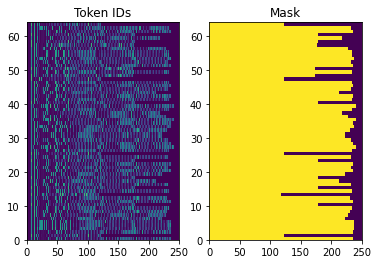

In [27]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

# The Model

In [28]:
embedding_dim = 128
units = 256

In [29]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")


In [30]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [31]:
# Convert the input text to tokens.
example_tokens = input_vectorize_layer(example_input_batch)

# Encode the input sequence.
encoder = Encoder(len(input_vectorize_layer.get_vocabulary()),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 250)
Encoder output, shape (batch, s, units): (64, 250, 256)
Encoder state, shape (batch, units): (64, 256)


## Attention Layer

In [32]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [33]:
attention_layer = BahdanauAttention(units)

In [34]:
(example_tokens != 0).shape

TensorShape([64, 250])

In [35]:
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

In [36]:
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)

In [37]:
print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 256)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 250)


Text(0.5, 1.0, 'Mask')

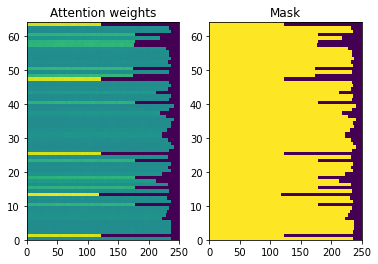

In [38]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

## Decoder

In [39]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)


In [40]:
import typing
from typing import Any, Tuple
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [41]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [42]:
Decoder.call = call

In [43]:
decoder = Decoder(len(output_vectorize_layer.get_vocabulary()),
    embedding_dim, units)

In [44]:
example_output_tokens = output_vectorize_layer(example_target_batch)

start_index = output_vectorize_layer.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])


In [45]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')


logits shape: (batch_size, t, output_vocab_size) (64, 1, 165)
state shape: (batch_size, dec_units) (64, 256)


In [46]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
vocab = np.array(output_vectorize_layer.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['1/648'],
       ['d^(*)'],
       ['A'],
       ['4/9'],
       ['(p_2)']], dtype='<U8')

In [47]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [48]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]


array([['s_25'],
       ['alpha_3'],
       ['-1/4'],
       ['(p_2)_u'],
       ['i_2']], dtype='<U8')

## Training

In [49]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [50]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(len(input_vectorize_layer.get_vocabulary()),
                      embedding_dim, units)
    decoder = Decoder(len(output_vectorize_layer.get_vocabulary()),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_vectorize_layer
    self.output_text_processor = output_vectorize_layer
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)


In [51]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask
TrainTranslator._preprocess = _preprocess

In [52]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}
TrainTranslator._train_step = _train_step


In [53]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [54]:
TrainTranslator._loop_step = _loop_step

In [55]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_vectorize_layer,
    output_text_processor=output_vectorize_layer,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [56]:
np.log(len(output_vectorize_layer.get_vocabulary()))

5.105945473900581

In [57]:
# %%time
# for n in range(20):
#   print(translator.train_step([example_input_batch, example_target_batch]))
# print()


In [58]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

TrainTranslator._tf_train_step = _tf_train_step
translator.use_tf_function = True

In [59]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.083062>}

In [60]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.058987>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.029543>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.985088>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9142094>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8004684>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.619523>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3588667>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.56096>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.235846>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.18982>}

CPU times: user 1min 6s, sys: 14.8 s, total: 1min 21s
Wall time: 24.2 s


In [61]:
losses = []
for n in range(50):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)


.......

KeyboardInterrupt: ignored

## Full Training

In [62]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_vectorize_layer,
    output_text_processor=output_vectorize_layer)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [63]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [64]:
train_translator.fit(dataset, epochs=20,
                     callbacks=[batch_loss])

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

## Translate

In [65]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))


In [66]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_vectorize_layer,
    output_text_processor=output_vectorize_layer,
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [67]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [68]:
Translator.tokens_to_text = tokens_to_text

In [69]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=len(output_vectorize_layer.get_vocabulary()))
translator.tokens_to_text(example_output_tokens).numpy()


array([b'-1/48 b^(*)', b'2/9 alpha_5', b'd (p_4)_u', b'1/2 s_14',
       b'mu (p_1)_u'], dtype=object)

In [70]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [71]:
Translator.sample = sample

In [72]:
example_logits = tf.random.normal([5, 1, len(output_vectorize_layer.get_vocabulary())])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 21],
       [ 30],
       [ 30],
       [ 23],
       [159]])>

In [73]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [74]:
Translator.translate = translate_unrolled

In [75]:
%%time
input_text = tf.constant([
    'Prod -1/6 Prod i Prod Pow e 4 Prod Pow Sum Pow m_c 2 Sum s_23',
    'Prod 1/324 Prod i Prod Pow e 4 Prod Pow Sum Pow m_s 2 Sum Prod -1'
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


i_1 t^(*) reg_prop i_2 alpha_3 1/4 A^(*) t^(*) alpha_10 -1/8 1/16 1/9 u (p_4)_u i_5 3 alpha_2 s_45 s_23 p_1 i_2 -1/162 4 (p_3)_u s_15 -1/48 -1/72 c -1/108 4/27 m_t i_2 -4/27 d^(*) (p_4)_v (p_6)_u Pow s_12 3 1/216 -1/108 (p_5)_u s_23 1/24 (p_3) 1/72 ee (p_4)_v 1/108 3
m_c (p_2) 2/27 1/6 s_12 tt^(*) -1/6 alpha_14 -1/36 s i_5 Pow alpha_23 alpha_12 Pow 1/16 4/9 alpha_14 (p_3)_u alpha_24 gamma -1/81 c^(*) -1/4 -1/4 alpha_24 p_2 1/324 1/3 s_23 4/9 p_4 1/81 (p_2) alpha_2 p_5 alpha_1 i -2/9 1/2 m_mu (p_4)_u (p_4)_v 1/6 -2/27 2/81 1/1296 -2/81 s p_2

CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 1.38 s


# Export

In [76]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [77]:
%%time
result = translator.tf_translate(
    input_text = input_text)
# first time takes long because of compiling


CPU times: user 22.9 s, sys: 78.5 ms, total: 22.9 s
Wall time: 22.7 s


In [78]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

ee s -1/16 b 2/9 -1/6 (p_4)_u ee^(*) 1/162 (p_2)
1/1296 m_tt -1/648 alpha_5 -1/108 m_e 1/36 (p_3)_v 1/1296 alpha_21 1/48 alpha_2 3 ee^(*) m_c alpha_1 (p_4)_u -1/3 -8/27 (p_1)_v i_4 1/324 alpha_5 2/27 alpha_17 s^(*) m_mu 1/108 tt^(*) alpha_11 (p_2)_v m_tt

CPU times: user 143 ms, sys: 14.1 ms, total: 157 ms
Wall time: 83.1 ms


## Use Symbolic Loop

In [79]:
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [80]:
Translator.translate = translate_symbolic

In [81]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


alpha_17 i p_3 1/27 1/18 alpha_13 alpha_7 alpha_3 -1/2 s_13 u^(*) 1/24 1/216 1/324 -1/162 Pow (p_4) (p_1) -1/24 e alpha_1 d^(*) alpha_6 i_1 -1/216 m_e ee^(*) mu^(*) -1/18 1/4 alpha_1 p_4 1/3 2/3 gamma t 1/54 -1/18 alpha_23 alpha_0 p_3 i_5 -1/54 alpha_22 m_mu alpha_10 -1/6 alpha_21 (p_1)_v -4/9
i_2 s m_d -1/18 alpha_10 s_45 -1/72 s_13 1/6 m_u -4/27 s_15 alpha_20 i -1/216 -1/324 (p_5) alpha_18 4 (p_1)_v i_1 reg_prop -1/81 i alpha_5 p_5 1/1296 alpha_10 4/27 s_24 m_mu 3 (p_3)_v s_12 4 -1/648 (p_5)_v -1 m_mu p_1 t e ee^(*) tt^(*) mu t 1/3 -1/2 u^(*) 3

CPU times: user 1.48 s, sys: 10.8 ms, total: 1.49 s
Wall time: 1.46 s


In [82]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [83]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 2.28 s, sys: 31.5 ms, total: 2.31 s
Wall time: 2.13 s


In [84]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


tt^(*) i_2 alpha_22 2/81 s_45 p_2 alpha_8 8/27 alpha_24 m_tt -1/16 -1/216 s_14 m_tt -2/27 2 (p_2)_u -1/24 b alpha_12 m_e (p_2)_u
1/324 1/48 tt^(*) -8/27 (p_2)_v -1/27 u 1/12 -1/12 (p_3)_u mu -1/18 (p_1)_v m_d mu^(*) alpha_15 m_mu 1/4 alpha_22 1/324 1/36 s_25 alpha_18 1/81 s_14 -1/24 A -2/27 i_4 m_d -1/48 alpha_14 s_45 (p_4)_u 4/27 1/16 -1/4 1/2 u^(*) alpha_18 i_2 1/72 -1/72 -1/36 i_5 mu^(*) s^(*) s alpha_9 1/54

CPU times: user 222 ms, sys: 42.1 ms, total: 264 ms
Wall time: 104 ms


## Export

In [ ]:
tf.saved_model.save(translator, 'models/2022-07-19-RNNAttention',
                    signatures={'serving_default': translator.tf_translate})

In [85]:
reloaded = tf.saved_model.load('models/2022-07-19-RNNAttention')

In [86]:
%%time
result = reloaded.tf_translate(input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()


ee -1/6 Prod i Prod Pow e 2 Prod Pow Sum s_13 Prod 1/2 reg_prop -1 Sum Prod p_1 s_35 Prod gamma s_35 alpha_21 alpha_2 Prod gamma alpha_14 alpha_21 alpha_2 Prod gamma alpha_1 alpha_21 alpha_3 Prod ee i_1 alpha_17 (p_1)_u Prod ee^(*) i_3 alpha_13 (p_6)_u Prod mu i_4 alpha_18 (p_2)_u
Prod -1/2 Prod i Prod Pow e 2 Prod Pow Sum Pow m_s 2 Sum Prod -1 s_35 Prod 1/2 reg_prop -1 Prod Pow Sum Pow m_s 2 Sum s_13 Prod -1 s_13 Prod -1 s_34 Prod 1/2 reg_prop -1 Sum Prod p_1 alpha_14 Prod gamma alpha_14 alpha_4 alpha_4 Prod

CPU times: user 497 ms, sys: 52.7 ms, total: 550 ms
Wall time: 381 ms


# Evaluation

In [140]:
result = reloaded.tf_translate(X_test_text)

y_pred = []
for tr in result['text']:
  y_pred.append(tr.numpy().decode())

In [141]:
y_pred[0]

'Prod -1/54 Prod i Prod Pow e 4 Prod Pow Sum Pow m_mu 2 Sum Prod -1 s_14 Prod 1/2 reg_prop -1 Prod Pow Sum Pow m_s 2 Sum s_23 Prod 1/2 reg_prop -1 Prod Pow Sum Pow m_mu 2 Sum Prod -1 s_14 Prod -1 s_15 s_45 Prod 1/2'

In [142]:
y_test_text[0]

'[START] Prod -1/54 Prod i Prod Pow e 4 Prod Pow Sum Pow m_mu 2 Sum Prod -1 s_14 Prod 1/2 reg_prop -1 Prod Pow Sum Pow m_s 2 Sum s_23 Prod 1/2 reg_prop -1 Prod Pow Sum Pow m_mu 2 Sum Prod -1 s_14 Prod -1 s_15 s_45 Prod 1/2 reg_prop -1 Sum Prod p_1 alpha_14 Prod gamma alpha_1 alpha_16 alpha_4 Prod gamma alpha_1 alpha_2 alpha_5 Prod gamma alpha_0 alpha_19 alpha_21 Prod gamma alpha_0 alpha_23 alpha_3 Prod gamma alpha_14 alpha_4 alpha_23 Prod c^(*) i_2 alpha_16 (p_5)_u Prod c i_3 alpha_3 (p_6)_v Prod s i_5 alpha_21 (p_2)_u Prod s^(*) i_0 alpha_19 (p_3)_v Prod mu i_1 alpha_5 (p_1)_u mu^(*) i_4 alpha_2 (p_4)_u Sum Prod -1 Prod p_4 alpha_14 Prod gamma alpha_1 alpha_15 alpha_12 Prod gamma alpha_1 alpha_10 alpha_13 Prod gamma alpha_0 alpha_20 alpha_8 Prod gamma alpha_0 alpha_11 alpha_7 Prod gamma alpha_14 alpha_12 alpha_11 Prod c^(*) i_2 alpha_15 (p_5)_u Prod c i_3 alpha_7 (p_6)_v Prod s i_5 alpha_8 (p_2)_u Prod s^(*) i_0 alpha_20 (p_3)_v Prod mu i_1 alpha_13 (p_1)_u mu^(*) i_4 alpha_10 (p_4)_u

In [143]:
def token_accuracy(y_true, y_pred, verbose=0):
    """
    compare two arrays and check how many entries are the same at the same position
    """
    max_ind = np.min([len(y_true), len(y_pred)])
    correct_ctr = 0
    # ignore [start] and [end]
    max_correct = len(y_test)
    for i in range(1, max_ind-1):
        if verbose: ic([y_true[i], y_pred[i]])
        if y_true[i] == y_pred[i]:
            correct_ctr += 1
    return correct_ctr / max_correct

In [148]:
def evaluate_model(y_test, y_pred):
    y_pred_split = [y.split() for y in y_pred]
    y_test_split = [y.split()[1:-1] for y in y_test] # don't want [Start], [End]
    acc = []
    for i in range(len(y_test)):
        acc.append(token_accuracy(y_test_split[i], y_pred_split[i]))
    return np.mean(acc)

In [149]:
evaluate_model(y_test_text, y_pred)

0.006388194360143593